In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

your 131072x1 screen size is bogus. expect trouble


23/05/24 16:13:03 WARN Utils: Your hostname, HOMELAB resolves to a loopback address: 127.0.1.1; using 192.168.75.74 instead (on interface eth0)
23/05/24 16:13:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/24 16:13:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.functions import col, lit

from common import *

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
PREFIX = "main/ycsb-asym"

IGNORE_CACHE = False

index_df = from_cache_or_compute(
    f'{PREFIX}/index.parquet',
    lambda: get_index(spark, PREFIX)\
        .withColumn("asym_ratio", F.regexp_extract("prefix", r"asym_ratio(\d+)", 1))\
        .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))\
        .toPandas()\
        .convert_dtypes()\
        .astype({
            "wl:hot": "int32",
            "wl:mh": "int32",
            "wl:mp": "int32",
        }),
    ignore_cache=IGNORE_CACHE,
)

index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,asym_ratio
0,file:/home/ctring/data/detock/main/ycsb-asym/d...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,50
1,file:/home/ctring/data/detock/main/ycsb-asym/d...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,60
2,file:/home/ctring/data/detock/main/ycsb-asym/d...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,70
3,file:/home/ctring/data/detock/main/ycsb-asym/d...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,80
4,file:/home/ctring/data/detock/main/ycsb-asym/d...,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,90
5,file:/home/ctring/data/detock/main/ycsb-asym/d...,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,50
6,file:/home/ctring/data/detock/main/ycsb-asym/d...,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,60
7,file:/home/ctring/data/detock/main/ycsb-asym/d...,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,70
8,file:/home/ctring/data/detock/main/ycsb-asym/d...,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,80
9,file:/home/ctring/data/detock/main/ycsb-asym/d...,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,90


# Throughput

In [4]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=10,
        duration_sec=50
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_df):
    # Extract all prefixes in the index
    throughput_df = index_df.loc[:, ["prefix"]]
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")


throughput_df = from_cache_or_compute(
    f'{PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(index_df[index_df["clients"] == 3000])\
        .sort_values("asym_ratio"),
    ignore_cache=IGNORE_CACHE,
)

# Latency

In [5]:
IGNORE_CACHE = False

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("p50"),
    F.percentile_approx("latency", 0.90).alias("p90"),
    F.percentile_approx("latency", 0.95).alias("p95"),
    F.percentile_approx("latency", 0.99).alias("p99"),
]

latency_df = from_cache_or_compute(
    f'{PREFIX}/latency.parquet',
    lambda:  latency(
        spark,
        index_df.loc[index_df["clients"] == 200, "prefix"]
    )\
        .groupBy("prefix")\
        .agg(*percentile_cols)\
        .toPandas()\
        .merge(index_df, on="prefix")\
        .sort_values("asym_ratio"),
    ignore_cache=IGNORE_CACHE,
)

latency_df

,prefix,p50,p90,p95,p99,version,config_name,duration,txns,clients,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,asym_ratio
index,,,,,,,,,,,,,,,,,,,,,
1,file:/home/ctring/data/detock/main/ycsb-asym/d...,87.998208,124.995072,140.085248,220.053504,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,50
3,file:/home/ctring/data/detock/main/ycsb-asym/d...,95.744512,140.546816,157.972224,224.577536,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,60
0,file:/home/ctring/data/detock/main/ycsb-asym/d...,105.878528,156.081408,175.148288,246.063360,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,70
4,file:/home/ctring/data/detock/main/ycsb-asym/d...,120.099072,176.145664,197.913856,266.996224,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,80
2,file:/home/ctring/data/detock/main/ycsb-asym/d...,127.725056,188.514816,212.547584,294.964224,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,90


# Plot

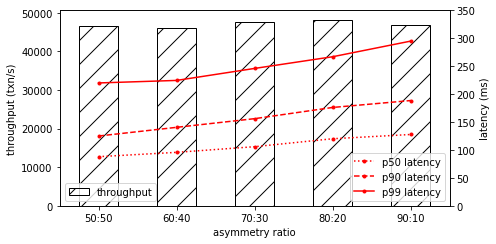

In [6]:
_, ax = plt.subplots(1, 1, figsize=(7, 3.5))

throughput_df.plot.bar(ax=ax, x="asym_ratio", y="throughput", rot=0, fill=False, hatch='/')
ax.set_ylabel("throughput (txn/s)")
ax.set_xlabel("asymmetry ratio")
ax.legend(loc="lower left")
ax2 = ax.twinx()

latency_df.plot(ax=ax2, x="asym_ratio", y="p50", label='p50 latency', linestyle='dotted', marker='.', color="red")
latency_df.plot(ax=ax2, x="asym_ratio", y="p90", label='p90 latency', linestyle='dashed', marker='.', color="red")
latency_df.plot(ax=ax2, x="asym_ratio", y="p99", label='p99 latency', marker='.', color="red")
ax2.set_ylabel("latency (ms)")
ax2.set_ylim((0, 350))
ax2.set_xticklabels(["50:50", "60:40", "70:30", "80:20", "90:10"])

ax2.legend(loc="lower right", ncol=1)
 
plt.tight_layout()
plt.savefig("output/asymmetry.pdf")
